# FIKH Model: Startup Shear

## Learning Objectives

1. Fit the **FIKH model** to startup shear (stress overshoot) data
2. Understand how **alpha_structure** affects stress overshoot timing and magnitude
3. Analyze fractional breakdown dynamics during flow inception
4. Compare FIKH predictions across different alpha values
5. Use Bayesian inference to quantify parameter uncertainty

## Prerequisites

- NB01: FIKH Flow Curve (calibrated parameters)
- Bayesian inference fundamentals (bayesian/01_bayesian_basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

# Add examples/utils to path
# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_pnas_startup,
    save_fikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_fikh_param_names,
    plot_alpha_sweep,
    print_alpha_interpretation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Startup Shear with Fractional Memory

During startup shear at constant rate $\dot{\gamma}$, the FIKH model predicts:

1. **Initial elastic response**: $\sigma \approx G \cdot \gamma$
2. **Stress overshoot**: Peak occurs when plastic flow begins
3. **Steady-state approach**: Governed by structure evolution

### Alpha Effect on Startup

The fractional order $\alpha$ affects:
- **Overshoot timing**: Lower $\alpha$ → later peak (slower structure breakdown)
- **Overshoot magnitude**: Modified by memory kernel
- **Approach to steady-state**: Power-law vs exponential convergence

## 3. Load Data

In [3]:
# Load PNAS startup data at gamma_dot = 1.0 s^-1
GAMMA_DOT = 1.0
time_data, stress_data = load_pnas_startup(gamma_dot=GAMMA_DOT)

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")
print(f"Shear rate: {GAMMA_DOT} 1/s")

Data points: 500
Time range: [0.0053, 600.00] s
Stress range: [0.69, 26.77] Pa
Shear rate: 1.0 1/s


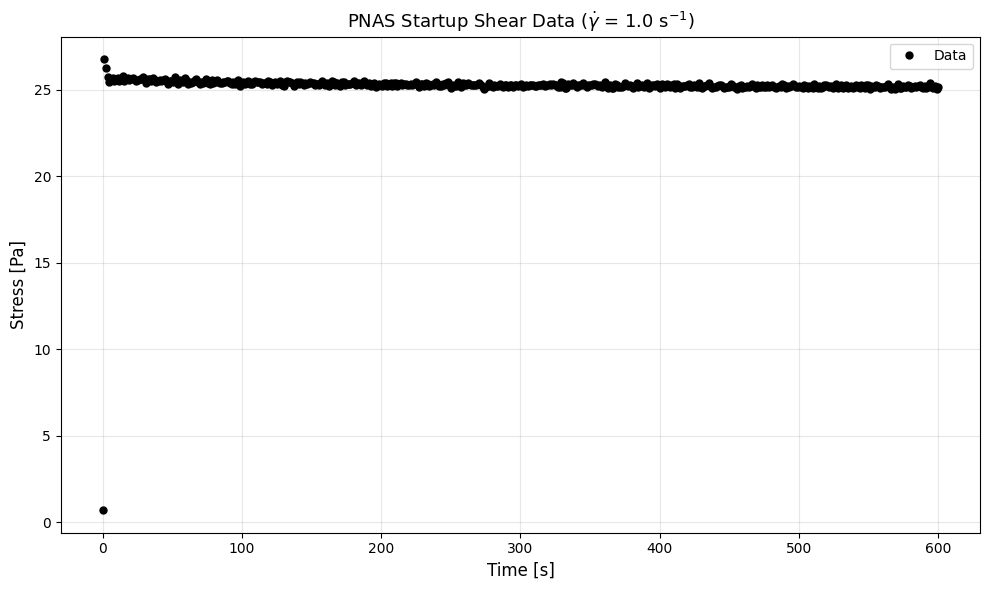

In [4]:
# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, stress_data, "ko", markersize=5, label="Data")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"PNAS Startup Shear Data ($\\dot{{\\gamma}}$ = {GAMMA_DOT} s$^{{-1}}$)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit FIKH model
model = FIKH(include_thermal=False, alpha_structure=0.7)

# Compute strain from time and shear rate
strain_data = GAMMA_DOT * time_data

t0 = time.time()
model.fit(time_data, stress_data, test_mode="startup", strain=strain_data, method='scipy')
t_nlsq = time.time() - t0

param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fikh.py", line 467, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ fit time: 0.12 s

Fitted parameters:
  G               = 282.8
  eta             = 3.135e+07
  C               = 499.6
  gamma_dyn       = 1.899
  m               = 1
  sigma_y0        = 9.99
  delta_sigma_y   = 49.93
  tau_thix        = 94.25
  Gamma           = 2.728
  alpha_structure = 0.703
  eta_inf         = 0.09986
  mu_p            = 0.001



Fit Quality:
  R^2:   -44419.068507
  RMSE:  234.3 Pa


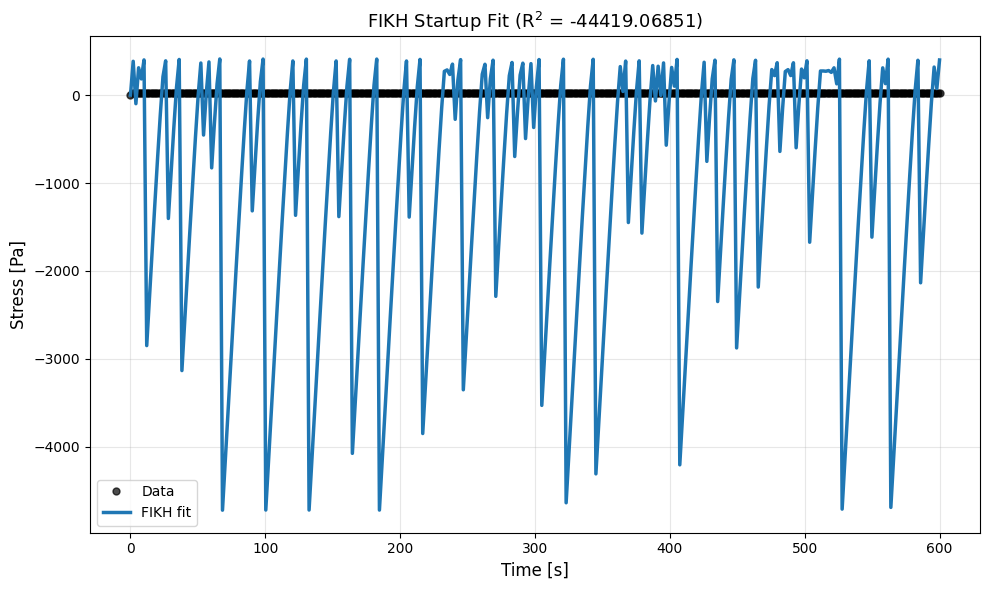

In [6]:
# Compute fit quality and plot
stress_pred = model.predict(time_data, test_mode="startup", strain=strain_data)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")

# Fine time array for smooth prediction
time_fine = np.linspace(0.01, time_data.max(), 300)
stress_pred_fine = model.predict(time_fine, test_mode="startup", strain=GAMMA_DOT * time_fine)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, stress_data, "ko", markersize=5, alpha=0.7, label="Data")
ax.plot(time_fine, stress_pred_fine, "-", lw=2.5, color="C0", label="FIKH fit")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"FIKH Startup Fit (R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Exploration

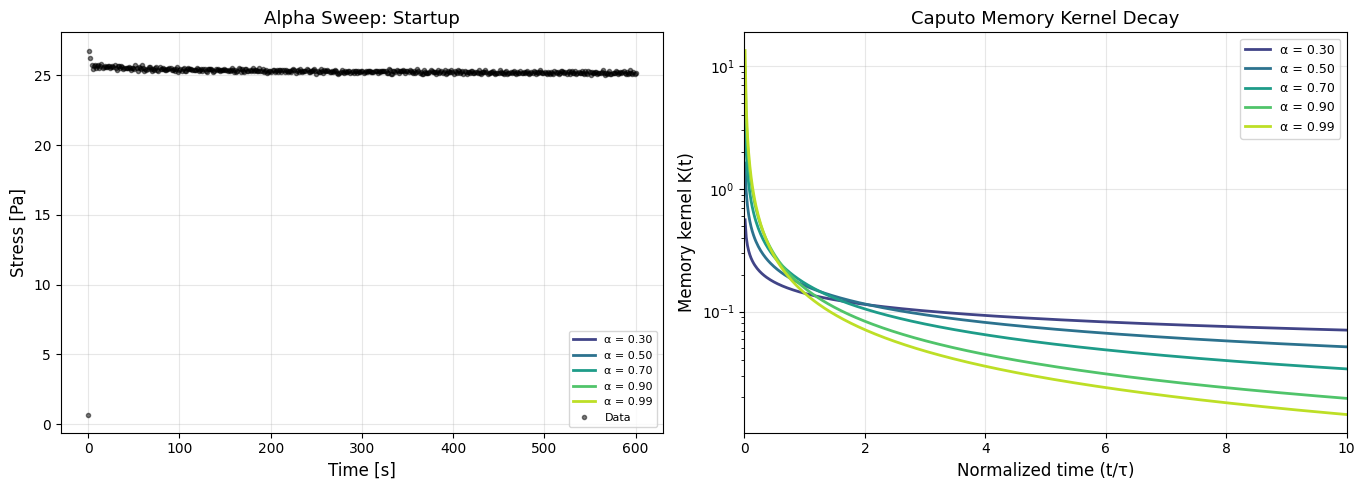

In [7]:
# Alpha sweep for startup shear
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="startup",
    alpha_values=alpha_values,
    x_data=time_fine,
    gamma_dot=GAMMA_DOT,
    figsize=(14, 5),
)

# Add data to left panel
fig.axes[0].plot(time_data, stress_data, "ko", markersize=3, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

In [8]:
# Physical interpretation
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.703

Regime: Weak Memory

Approaching classical behavior with mild power-law tails.
Recovery is mostly exponential with slow corrections.
Suitable for: Mildly thixotropic materials.

Physical Implications:
  • Memory kernel decay: t^(-0.70)
  • Recovery time scale: > τ_thix × Γ(1+0.70) = 0.91 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.70


## 6. Bayesian Inference

In [9]:
# Bayesian inference with NLSQ warm-start
initial_values = {name: model.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    time_data,
    stress_data,
    test_mode="startup",
    strain=strain_data,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<08:15,  1.41it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 11/700 [00:00<00:39, 17.36it/s, 3 steps of size 8.32e-08. acc. prob=0.45]

warmup:   2%|▏         | 16/700 [00:01<00:34, 20.05it/s, 7 steps of size 4.20e-08. acc. prob=0.60]

warmup:   3%|▎         | 23/700 [00:01<00:23, 28.56it/s, 19 steps of size 5.18e-09. acc. prob=0.67]

warmup:   5%|▍         | 32/700 [00:01<00:16, 40.70it/s, 3 steps of size 3.16e-08. acc. prob=0.76] 

warmup:   6%|▌         | 39/700 [00:01<00:16, 39.46it/s, 1 steps of size 1.79e-08. acc. prob=0.79]

warmup:   6%|▋         | 45/700 [00:01<00:16, 40.28it/s, 21 steps of size 4.22e-09. acc. prob=0.79]

warmup:   7%|▋         | 51/700 [00:01<00:15, 42.91it/s, 15 steps of size 1.11e-08. acc. prob=0.82]

warmup:   8%|▊         | 56/700 [00:01<00:16, 38.50it/s, 3 steps of size 1.73e-08. acc. prob=0.83] 

warmup:   9%|▉         | 62/700 [00:01<00:15, 42.24it/s, 7 steps of size 6.57e-09. acc. prob=0.83]

warmup:  10%|▉         | 67/700 [00:02<00:14, 42.67it/s, 1 steps of size 1.30e-08. acc. prob=0.85]

warmup:  11%|█         | 77/700 [00:02<00:11, 55.46it/s, 7 steps of size 1.68e-08. acc. prob=0.86]

warmup:  12%|█▏        | 83/700 [00:02<00:12, 51.00it/s, 15 steps of size 5.99e-09. acc. prob=0.86]

warmup:  13%|█▎        | 89/700 [00:02<00:13, 46.72it/s, 3 steps of size 1.16e-08. acc. prob=0.87] 

warmup:  14%|█▍        | 97/700 [00:02<00:11, 53.23it/s, 7 steps of size 1.58e-08. acc. prob=0.88]

warmup:  15%|█▍        | 103/700 [00:03<00:37, 16.06it/s, 7 steps of size 4.23e-08. acc. prob=0.88]

warmup:  15%|█▌        | 108/700 [00:03<00:32, 18.44it/s, 7 steps of size 3.90e-08. acc. prob=0.88]

warmup:  16%|█▌        | 112/700 [00:03<00:29, 19.66it/s, 7 steps of size 4.41e-08. acc. prob=0.89]

warmup:  17%|█▋        | 116/700 [00:04<00:27, 21.25it/s, 7 steps of size 5.13e-08. acc. prob=0.89]

warmup:  17%|█▋        | 120/700 [00:04<00:26, 22.30it/s, 3 steps of size 5.99e-08. acc. prob=0.89]

warmup:  18%|█▊        | 124/700 [00:04<00:23, 24.69it/s, 7 steps of size 6.95e-08. acc. prob=0.90]

warmup:  18%|█▊        | 129/700 [00:04<00:19, 29.49it/s, 7 steps of size 8.25e-08. acc. prob=0.90]

warmup:  19%|█▉        | 134/700 [00:04<00:17, 31.54it/s, 31 steps of size 9.67e-08. acc. prob=0.91]

warmup:  20%|█▉        | 138/700 [00:05<00:40, 13.74it/s, 15 steps of size 1.05e-07. acc. prob=0.91]

warmup:  20%|██        | 141/700 [00:05<00:35, 15.61it/s, 3 steps of size 1.14e-07. acc. prob=0.91] 

warmup:  21%|██        | 144/700 [00:05<00:40, 13.64it/s, 3 steps of size 1.22e-07. acc. prob=0.91]

warmup:  21%|██        | 147/700 [00:05<00:35, 15.48it/s, 3 steps of size 1.32e-07. acc. prob=0.91]

warmup:  21%|██▏       | 150/700 [00:06<00:40, 13.69it/s, 63 steps of size 1.41e-07. acc. prob=0.92]

warmup:  23%|██▎       | 158/700 [00:06<00:23, 22.68it/s, 3 steps of size 8.88e-07. acc. prob=0.92] 

warmup:  24%|██▍       | 167/700 [00:06<00:15, 33.82it/s, 3 steps of size 8.50e-07. acc. prob=0.92]

warmup:  25%|██▍       | 172/700 [00:09<01:28,  5.99it/s, 1023 steps of size 1.09e-07. acc. prob=0.92]

warmup:  25%|██▌       | 177/700 [00:09<01:06,  7.81it/s, 7 steps of size 1.39e-07. acc. prob=0.92]   

warmup:  26%|██▌       | 183/700 [00:09<00:48, 10.74it/s, 3 steps of size 1.83e-07. acc. prob=0.92]

warmup:  27%|██▋       | 189/700 [00:09<00:42, 12.04it/s, 127 steps of size 2.10e-07. acc. prob=0.93]

warmup:  28%|██▊       | 194/700 [00:09<00:33, 15.02it/s, 15 steps of size 2.53e-07. acc. prob=0.93] 

warmup:  28%|██▊       | 199/700 [00:10<00:30, 16.47it/s, 63 steps of size 2.79e-07. acc. prob=0.93]

sample:  29%|██▉       | 206/700 [00:10<00:21, 22.67it/s, 3 steps of size 2.33e-07. acc. prob=1.00] 

sample:  30%|███       | 213/700 [00:10<00:17, 28.53it/s, 15 steps of size 2.33e-07. acc. prob=1.00]

sample:  32%|███▏      | 221/700 [00:10<00:13, 36.81it/s, 7 steps of size 2.33e-07. acc. prob=1.00] 

sample:  32%|███▏      | 227/700 [00:10<00:11, 39.52it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  33%|███▎      | 234/700 [00:10<00:11, 39.49it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  34%|███▍      | 239/700 [00:10<00:11, 41.13it/s, 3 steps of size 2.33e-07. acc. prob=1.00] 

sample:  35%|███▍      | 244/700 [00:10<00:11, 40.04it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  36%|███▌      | 249/700 [00:11<00:10, 41.54it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  36%|███▋      | 254/700 [00:11<00:10, 42.26it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  37%|███▋      | 259/700 [00:11<00:11, 38.84it/s, 15 steps of size 2.33e-07. acc. prob=1.00]

sample:  38%|███▊      | 266/700 [00:11<00:09, 44.73it/s, 3 steps of size 2.33e-07. acc. prob=1.00] 

sample:  39%|███▉      | 274/700 [00:11<00:08, 52.78it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  40%|████      | 280/700 [00:11<00:08, 52.10it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  41%|████      | 286/700 [00:12<00:13, 30.58it/s, 127 steps of size 2.33e-07. acc. prob=1.00]

sample:  42%|████▏     | 291/700 [00:12<00:12, 32.27it/s, 7 steps of size 2.33e-07. acc. prob=1.00]  

sample:  43%|████▎     | 299/700 [00:12<00:10, 39.84it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  43%|████▎     | 304/700 [00:12<00:10, 38.50it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  44%|████▍     | 309/700 [00:12<00:09, 39.30it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  45%|████▍     | 314/700 [00:12<00:09, 38.76it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  46%|████▌     | 319/700 [00:12<00:11, 32.32it/s, 7 steps of size 2.33e-07. acc. prob=1.00] 

sample:  46%|████▋     | 325/700 [00:13<00:10, 37.12it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  48%|████▊     | 333/700 [00:13<00:08, 45.11it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  48%|████▊     | 338/700 [00:13<00:09, 38.57it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  49%|████▉     | 346/700 [00:13<00:07, 46.59it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  50%|█████     | 352/700 [00:13<00:07, 44.26it/s, 15 steps of size 2.33e-07. acc. prob=1.00]

sample:  51%|█████     | 357/700 [00:13<00:07, 45.10it/s, 3 steps of size 2.33e-07. acc. prob=1.00] 

sample:  52%|█████▏    | 362/700 [00:14<00:11, 28.32it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  52%|█████▏    | 366/700 [00:14<00:11, 29.74it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  53%|█████▎    | 370/700 [00:14<00:11, 28.44it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  53%|█████▎    | 374/700 [00:14<00:11, 29.38it/s, 7 steps of size 2.33e-07. acc. prob=1.00] 

sample:  54%|█████▍    | 378/700 [00:14<00:17, 18.73it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  54%|█████▍    | 381/700 [00:15<00:17, 18.53it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  55%|█████▍    | 384/700 [00:15<00:15, 19.85it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  56%|█████▌    | 389/700 [00:15<00:13, 22.39it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  56%|█████▌    | 392/700 [00:15<00:13, 23.07it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  57%|█████▋    | 398/700 [00:15<00:10, 29.96it/s, 3 steps of size 2.33e-07. acc. prob=1.00] 

sample:  58%|█████▊    | 403/700 [00:15<00:08, 33.54it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  58%|█████▊    | 407/700 [00:15<00:08, 34.55it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  59%|█████▉    | 412/700 [00:15<00:08, 33.71it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  59%|█████▉    | 416/700 [00:16<00:11, 25.67it/s, 15 steps of size 2.33e-07. acc. prob=1.00]

sample:  61%|██████    | 424/700 [00:16<00:08, 34.20it/s, 7 steps of size 2.33e-07. acc. prob=1.00] 

sample:  61%|██████    | 428/700 [00:16<00:08, 30.60it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  62%|██████▏   | 432/700 [00:16<00:08, 31.00it/s, 7 steps of size 2.33e-07. acc. prob=1.00] 

sample:  62%|██████▏   | 437/700 [00:16<00:07, 35.12it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  63%|██████▎   | 441/700 [00:16<00:08, 30.93it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  64%|██████▍   | 448/700 [00:17<00:06, 39.35it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  65%|██████▍   | 453/700 [00:17<00:06, 38.84it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  65%|██████▌   | 458/700 [00:17<00:07, 33.77it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  66%|██████▋   | 464/700 [00:17<00:06, 38.41it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  67%|██████▋   | 469/700 [00:17<00:06, 34.89it/s, 15 steps of size 2.33e-07. acc. prob=1.00]

sample:  68%|██████▊   | 473/700 [00:17<00:07, 30.38it/s, 31 steps of size 2.33e-07. acc. prob=1.00]

sample:  69%|██████▊   | 481/700 [00:18<00:06, 31.48it/s, 63 steps of size 2.33e-07. acc. prob=1.00]

sample:  69%|██████▉   | 485/700 [00:18<00:06, 32.17it/s, 7 steps of size 2.33e-07. acc. prob=1.00] 

sample:  70%|███████   | 491/700 [00:18<00:05, 37.70it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  71%|███████   | 496/700 [00:18<00:05, 40.10it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  72%|███████▏  | 501/700 [00:18<00:04, 41.91it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  72%|███████▏  | 506/700 [00:18<00:04, 41.30it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  73%|███████▎  | 511/700 [00:18<00:04, 43.45it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  74%|███████▎  | 516/700 [00:18<00:04, 40.92it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  74%|███████▍  | 521/700 [00:19<00:04, 38.43it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  75%|███████▌  | 526/700 [00:19<00:04, 40.71it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  76%|███████▌  | 531/700 [00:19<00:04, 39.59it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  77%|███████▋  | 538/700 [00:19<00:04, 35.87it/s, 63 steps of size 2.33e-07. acc. prob=1.00]

sample:  78%|███████▊  | 545/700 [00:19<00:03, 42.55it/s, 3 steps of size 2.33e-07. acc. prob=1.00] 

sample:  79%|███████▉  | 552/700 [00:19<00:03, 48.15it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  80%|███████▉  | 558/700 [00:19<00:03, 46.14it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  80%|████████  | 563/700 [00:19<00:02, 46.97it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  81%|████████  | 568/700 [00:20<00:03, 43.54it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  82%|████████▏ | 573/700 [00:20<00:03, 42.01it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  83%|████████▎ | 578/700 [00:20<00:03, 40.27it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  83%|████████▎ | 583/700 [00:20<00:03, 31.04it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  84%|████████▍ | 587/700 [00:20<00:03, 30.88it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  84%|████████▍ | 591/700 [00:20<00:04, 25.04it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  85%|████████▌ | 598/700 [00:21<00:03, 33.46it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  86%|████████▌ | 603/700 [00:21<00:03, 24.76it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  87%|████████▋ | 612/700 [00:21<00:02, 35.31it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  88%|████████▊ | 619/700 [00:21<00:01, 40.93it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  89%|████████▉ | 626/700 [00:21<00:01, 46.31it/s, 15 steps of size 2.33e-07. acc. prob=1.00]

sample:  90%|█████████ | 632/700 [00:21<00:01, 45.80it/s, 7 steps of size 2.33e-07. acc. prob=1.00] 

sample:  91%|█████████ | 638/700 [00:22<00:02, 24.90it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  92%|█████████▏| 643/700 [00:22<00:02, 26.79it/s, 15 steps of size 2.33e-07. acc. prob=1.00]

sample:  93%|█████████▎| 648/700 [00:22<00:01, 30.02it/s, 3 steps of size 2.33e-07. acc. prob=1.00] 

sample:  94%|█████████▎| 656/700 [00:23<00:01, 22.37it/s, 154 steps of size 2.33e-07. acc. prob=1.00]

sample:  95%|█████████▍| 663/700 [00:23<00:01, 28.40it/s, 3 steps of size 2.33e-07. acc. prob=1.00]  

sample:  96%|█████████▌| 672/700 [00:23<00:00, 37.76it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample:  97%|█████████▋| 678/700 [00:23<00:00, 40.57it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  98%|█████████▊| 684/700 [00:23<00:00, 35.87it/s, 7 steps of size 2.33e-07. acc. prob=1.00]

sample:  99%|█████████▉| 693/700 [00:23<00:00, 45.60it/s, 3 steps of size 2.33e-07. acc. prob=1.00]

sample: 100%|██████████| 700/700 [00:23<00:00, 29.28it/s, 3 steps of size 2.33e-07. acc. prob=1.00]


Bayesian inference time: 26.9 s


In [10]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
            eta    1.0000       500      PASS
              C    1.0000       500      PASS
      gamma_dyn    1.0000       500      PASS
              m    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
  delta_sigma_y    1.0000       500      PASS
       tau_thix    1.0000       500      PASS
          Gamma    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
        eta_inf    1.0000       500      PASS
           mu_p    1.0000       500      PASS

Divergences: 2

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


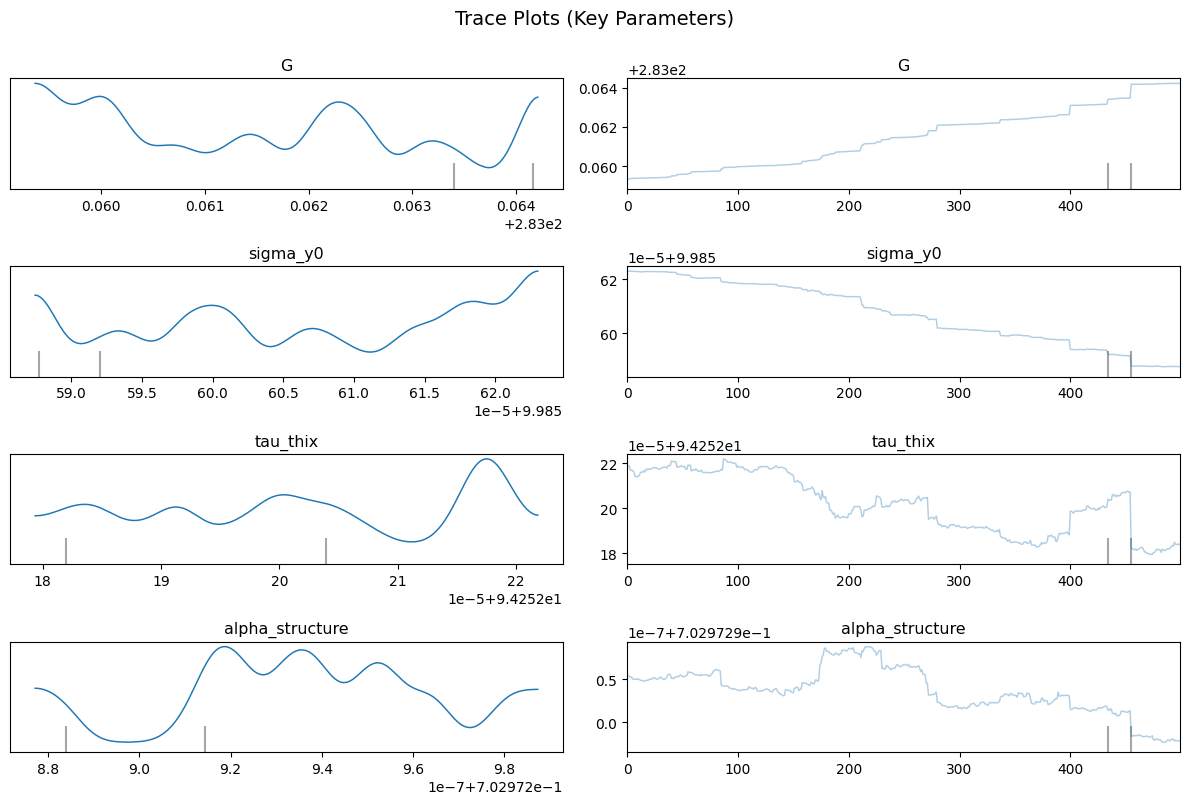

In [11]:
# Trace plots
idata = result.to_inference_data()
key_params = ["G", "sigma_y0", "tau_thix", "alpha_structure"]
axes = az.plot_trace(idata, var_names=key_params, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Key Parameters)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

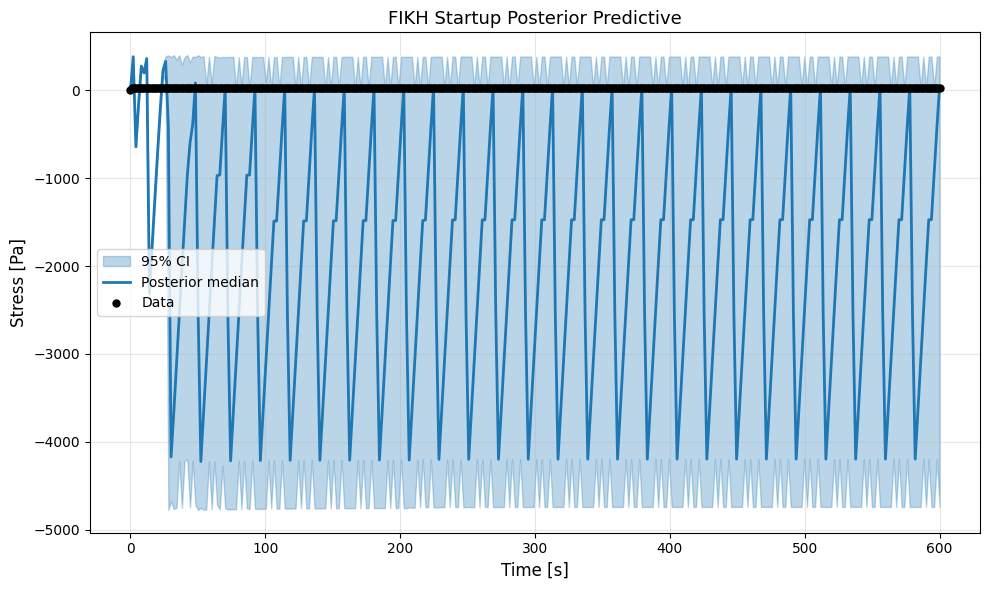

In [12]:
# Posterior predictive
posterior = result.posterior_samples
# FAST mode: 10 draws for batch testing
# FULL mode: 100 draws for publication
FAST_POSTERIOR_PREDICTIVE = True
n_draws = min(10 if FAST_POSTERIOR_PREDICTIVE else 100, len(list(posterior.values())[0]))

pred_samples = []
for i in range(n_draws):
    # Set model parameters from posterior sample
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(time_fine, test_mode="startup", strain=GAMMA_DOT * time_fine)
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(time_fine, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.plot(time_fine, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.plot(time_data, stress_data, "ko", markersize=5, label="Data")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("FIKH Startup Posterior Predictive", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

In [13]:
# Parameter comparison
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         283.1         283.1  [283.1, 283.1]
            eta     3.135e+07     3.135e+07  [3.135e+07, 3.135e+07]
              C         494.3         494.3  [494.2, 494.3]
      gamma_dyn         1.924         1.924  [1.924, 1.924]
              m         1.012         1.012  [1.012, 1.012]
       sigma_y0         9.986         9.986  [9.986, 9.986]
  delta_sigma_y         49.92         49.92  [49.92, 49.92]
       tau_thix         94.25         94.25  [94.25, 94.25]
          Gamma         2.729         2.729  [2.729, 2.729]
alpha_structure         0.703         0.703  [0.703, 0.703]
        eta_inf       0.09986       0.09986  [0.09986, 0.09986]
           mu_p         0.001         0.001  [0.001, 0.001]


## 7. Save Results

In [14]:
save_fikh_results(model, result, "fikh", "startup", param_names)
print("\nResults saved for downstream analysis.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/startup/
  nlsq_params_startup.json: 12 parameters
  posterior_startup.json: 500 draws

Results saved for downstream analysis.


## Key Takeaways

1. **Startup shear reveals fractional dynamics** through stress overshoot behavior
2. **Lower alpha** → later overshoot peak, slower structure breakdown
3. **Higher alpha** → approaches classical IKH exponential behavior
4. **Startup data constrains kinematic hardening** parameters (C, gamma_dyn)
5. **Combined with flow curve data** provides better alpha constraints

### Next Steps

- **NB03**: Stress relaxation (power-law tails show alpha most clearly)
- **NB04**: Creep response (delayed yielding with memory)
- **NB06**: LAOS (intra-cycle memory effects)